In [165]:
import numpy as np
import pandas as pd
from scipy.stats import beta, cauchy, gamma, gaussian_kde
import time  # Pour suivre le temps d'exécution
import matplotlib.pyplot as plt

In [166]:
def prior(n, hyper):
    X_1 = beta.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def simu(tht1, tht2, sigm, n):
    A = np.random.normal(0, sigm, size=n + 30)
    U = A[2:(n + 2)]
    V = A[1:(n + 1)]
    W = A[0:n]
    return U + tht1 * V + tht2 * W

def distautcor(Z, X):
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)


In [167]:
def ABCbas(X, N, sigm, hyper):
    res = prior(N, hyper)
    dist = np.apply_along_axis(lambda x: distautcor(X - np.mean(X), simu(x[0], x[1], sigm, len(X))), 1, res)
    return res[np.argmin(dist), :]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Remplacer les zéros par une très petite valeur
    
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
    
def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = np.random.exponential(size=(L, 3))
    dist = np.apply_along_axis(lambda x: np.sum((statdir(prior(len(Q1), x)) - statdir(Q))**2), 1, hyper)
    return hyper[np.argmin(dist), :]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N):
    dist = np.zeros(N)
    n = Dat.shape[0]
    w = np.arange(0, n, 3)
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        dist[i] = np.abs(np.var(simu(parh1[j], parh2[j], si[i], n)[w]) - np.var(Dat[w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    n = len(sigm)
    pri = np.abs(cauchy.rvs(size=2*Q)).reshape((Q, 2))
    for i in range(Q):
        h = pri[i]
        
        # Générer une valeur pour h[0] et h[1]
        while True:
            try:
                y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
                break
            except OverflowError:
                # Si une erreur de dépassement de capacité se produit, ajustez les paramètres h[0] et h[1]
                h = np.abs(cauchy.rvs(size=2))
        
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist), :]


In [168]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, par1_real, par2_real, hyper_real, hypersigm_real):
    start_time = time.time()  
    hyper = np.zeros((Npts, 3))
    hyper[0, :] = np.random.exponential(size=3)
    par1 = np.full((Npts, X.shape[1]), np.nan)
    par2 = np.full((Npts, X.shape[1]), np.nan)
    sigm = np.full((Npts, X.shape[1]), np.nan)
    hypersigm = np.full((Npts, 2), np.nan)
    hypersigm[0, :] = np.abs(cauchy.rvs(size=2))
    sigm[0, :] = 1 / gamma.rvs(hypersigm[0, 0], scale=hypersigm[0, 1], size=X.shape[1])
    
    simu_results = []  # Liste pour stocker les simulations
    distances_par = []  # Liste pour stocker les distances
    poids = []  # Liste pour stocker les poids
    histeps = []  # Liste pour stocker l'historique des epsilons
    cpu_times = []  # Liste pour stocker les temps CPU pour chaque distance calculée
    eps = float('inf')  # Initialiser epsilon à l'infini
    
    for i in range(1, Npts):
        dist_i = []
        poids_i = np.full(X.shape[1], np.nan)
        iteration_start_time = time.time()  # Enregistrer le temps de début de l'itération
        for j in range(X.shape[1]):
            U = ABCbas(X[:, j], N, sigm[i - 1, :], hyper[i - 1, :])
            par1[i, j] = U[0]
            par2[i, j] = U[1]
            sigm[i, j] = ABCsigm(X, j, par1[i, :], par2[i, :], hypersigm[i - 1, 0], hypersigm[i - 1, 1], P)
            simu_j = simu(par1[i, j], par2[i, j], sigm[i, j], X.shape[0])
            simu_results.append(simu_j)
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
            poids_i[j] = 1 / (1 + dist)

        iteration_end_time = time.time()  # Enregistrer le temps de fin de l'itération
        cpu_time_for_iteration = iteration_end_time - iteration_start_time  # Calculer le temps CPU pour l'itération
        cpu_times.append(cpu_time_for_iteration)  # Ajouter le temps CPU à la liste

        eps = min(eps, max(dist_i))  # Mettre à jour epsilon avec la distance maximale de cette itération si elle est plus petite
        histeps.append(eps)  # Ajouter la valeur actuelle d'epsilon à l'historique
        if eps <= objectifeps:  # Vérifier si l'objectif est atteint
            print(f"Objectif epsilon atteint : {eps} <= {objectifeps}")
            break  # Sortir de la boucle si l'objectif est atteint

        hyper[i, :] = ABChaut(par1[i, :], par2[i, :], M)
        hypersigm[i, :] = ABCsigmhaut(sigm[i, :], P2)
        distances_par.append(dist_i)
        poids.append(poids_i / np.sum(poids_i))
        
    total_time = time.time() - start_time  # Calculer le temps total d'exécution
    
    distances_par = np.abs(np.var(par1) - np.var(par1_real))
    distances_hyper= np.abs(np.var(hyper) - np.var(hyper_real))
    distances_hypersigm = np.abs(np.var(hypersigm) - np.var(hypersigm_real))

    resultats = {
        "Paramètre_1": par1,
        "Paramètre_2":par2,
        'Hyperparamètres': hyper,
        'Hypersigma': hypersigm,
        'Distances paramètres': distances_par,
        'Distances hyperparamètres': distances_hyper,
        'Distances hypersigma': distances_hypersigm,
        'Historique des epsilons': histeps,
        'Temps CPU par itération': cpu_times,
        'Temps CPU total': total_time
    }
    
    # Pour imprimer les résultats avec des titres
    for titre, valeur in resultats.items():
        print(f"{titre}:")
        print(valeur)
        print("\n")  # Ajoute un espace entre chaque section pour la clarté

    return resultats  # Retourne le dictionnaire de résultats


In [169]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, par1_real, par2_real, hyper_real, hypersigm_real):
    start_time = time.time()  
    hyper = np.zeros((Npts, 3))
    par1 = np.full((Npts, X.shape[1]), np.nan)
    par2 = np.full((Npts, X.shape[1]), np.nan)
    sigm = np.full((Npts, X.shape[1]), np.nan)
    hypersigm = np.full((Npts, 2), np.nan)
    
    simu_results = []  # Liste pour stocker les simulations
    distances_par = []  # Liste pour stocker les distances
    histeps = []  # Liste pour stocker l'historique des epsilons
    cpu_times = []  # Liste pour stocker les temps CPU pour chaque distance calculée
    eps = float('inf')  # Initialiser epsilon à l'infini
    
    for i in range(Npts):
        if i == 0:  # Initialisation spécifique pour la première itération
            hyper[i, :] = np.random.exponential(size=3)
            hypersigm[i, :] = np.abs(cauchy.rvs(size=2))
            sigm[i, :] = 1 / gamma.rvs(hypersigm[i, 0], scale=hypersigm[i, 1], size=X.shape[1])
        dist_i = []
        iteration_start_time = time.time()  # Enregistrer le temps de début de l'itération
        for j in range(X.shape[1]):
            if i > 0:  # Pour les itérations suivantes, utilisez les valeurs mises à jour
                U = ABCbas(X[:, j], N, sigm[i - 1, :], hyper[i - 1, :])
            else:  # Pour la première itération, utilisez les valeurs initiales
                U = ABCbas(X[:, j], N, sigm[i, :], hyper[i, :])
            par1[i, j] = U[0]
            par2[i, j] = U[1]
            if i < Npts - 1:  # Éviter de calculer pour la dernière itération où ce n'est pas nécessaire
                sigm[i + 1, j] = ABCsigm(X, j, par1[i, :], par2[i, :], hypersigm[i, 0], hypersigm[i, 1], P)
            simu_j = simu(par1[i, j], par2[i, j], sigm[i, j], X.shape[0])
            simu_results.append(simu_j)
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)

        iteration_end_time = time.time()  # Enregistrer le temps de fin de l'itération
        cpu_time_for_iteration = iteration_end_time - iteration_start_time  # Calculer le temps CPU pour l'itération
        cpu_times.append(cpu_time_for_iteration)  # Ajouter le temps CPU à la liste

        eps = min(eps, max(dist_i))  # Mettre à jour epsilon avec la distance maximale de cette itération si elle est plus petite
        histeps.append(eps)  # Ajouter la valeur actuelle d'epsilon à l'historique
        if eps <= objectifeps:  # Vérifier si l'objectif est atteint
            print(f"Objectif epsilon atteint : {eps} <= {objectifeps}")
            break  # Sortir de la boucle si l'objectif est atteint

        if i < Npts - 1:  # Éviter de calculer pour la dernière itération où ce n'est pas nécessaire
            hyper[i + 1, :] = ABChaut(par1[i, :], par2[i, :], M)
            hypersigm[i + 1, :] = ABCsigmhaut(sigm[i, :], P2)
        distances_par.append(dist_i)
    
        
    total_time = time.time() - start_time  # Calculer le temps total d'exécution
    
    par1_estime = np.mean(par1)
    par2_estime = np.mean(par2)
    hyper_estime = [np.mean(hyper[:, 0]), np.mean(hyper[:, 1]), np.mean(hyper[:, 2])]
    hypersigm_estime = [np.mean(hypersigm[:, 0]), np.mean(hypersigm[:, 1])]

    # Convertir les listes en tableaux NumPy pour permettre la soustraction élément par élément
    hyper_estime = np.array(hyper_estime)
    hypersigm_estime = np.array(hypersigm_estime)
    hyper_real = np.array(hyper_real)
    hypersigm_real = np.array(hypersigm_real)

# Effectuer la soustraction élément par élément
    distance_par1 = np.abs(par1_estime - par1_real)
    distance_par2 = np.abs(par2_estime - par2_real)
    distances_hyper = np.abs(np.subtract(hyper_estime, hyper_real))
    distances_hypersigm = np.abs(np.subtract(hypersigm_estime, hypersigm_real))

    resultats = {
        "Paramètre_1": par1,
        "Paramètre_2":par2,
        'Hyperparamètres': hyper,
        'Hypersigma': hypersigm,
        'Distance paramètre 1': distance_par1,
        'Distance paramètre 2': distance_par2,
        'Distances hyperparamètre': distances_hyper,
        'Distances hypersigma': distances_hypersigm,
        'Historique des epsilons': histeps,
        'Temps CPU par itération': cpu_times,
        'Temps CPU total': total_time
    }
    
    # Pour imprimer les résultats avec des titres
    for titre, valeur in resultats.items():
        print(f"{titre}:")
        print(valeur)
        print("\n")  # Ajoute un espace entre chaque section pour la clarté

    return resultats  # Retourne le dictionnaire de résultats

In [170]:
l=50
X = np.random.normal(-5, 1, (20, l)) #data
N=1000 #n
P=100
P2=100
M=100
objectifeps=0.1
Npts=10
hyper_real= [1,2,3]
hypersigm_real= [1,1]
par1_real=2
par2_real=3

In [172]:
X

array([[-5.82769689, -3.52320445, -3.78728024, -2.74874963, -4.44431134,
        -5.13529579, -4.72412061, -6.4478776 , -6.50222569, -4.88027184,
        -6.60265159, -5.03332721, -6.2950899 , -4.74495168, -3.94042798,
        -6.11688067, -5.3689657 , -6.3005293 , -4.8590528 , -5.12482115,
        -6.4475371 , -4.66313597, -2.97173119, -3.79190522, -6.3383197 ,
        -4.07333706, -7.30923819, -5.11301375, -5.15308951, -5.70815507,
        -3.37024678, -4.85718319, -4.19585121, -4.73142424, -5.21138541,
        -4.89213954, -5.27277487, -5.99371978, -3.66426618, -5.46804463,
        -2.62333774, -5.50872099, -4.96764374, -5.7224532 , -5.97070087,
        -6.02047087, -5.35298648, -3.86213063, -5.10905596, -5.09942132],
       [-5.32678339, -5.47751771, -5.16512449, -4.21995003, -6.74010279,
        -4.48106962, -5.32689152, -4.08194948, -7.77110395, -6.09736795,
        -4.41950554, -2.75303611, -4.64092833, -3.55000057, -4.04219026,
        -3.64390476, -5.62551475, -4.42904109, -4.

In [171]:
toyG = GibbsABC(X, N, M, P, P2, Npts, objectifeps, par1_real, par2_real, hyper_real, hypersigm_real)
toyG

C:\Users\sarah\AppData\Local\Temp\ipykernel_17772\3082693489.py:10: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_17772\3082693489.py:37: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)


Paramètre_1:
[[-2.89234097e-01  2.04546629e-01  2.13920798e-02  2.42659786e-01
  -2.55327118e-01 -9.74619402e-02  2.58608564e-01 -2.50122501e-01
  -2.87990641e-01 -4.30591599e-01 -2.85428134e-01  8.04473361e-02
   2.93312648e-01  5.17152277e-02 -1.88651389e-01  2.12065456e-01
   1.63720141e-02  8.09482271e-01  1.46085778e-01 -2.78495253e-02
  -3.63703411e-01  4.13357599e-02 -8.32484635e-03 -7.23045633e-02
  -1.01348191e-01  4.51667236e-01 -1.10742782e-01 -1.99001983e-01
   2.43580606e-01 -2.74074474e-01  3.16764736e-02  9.51271386e-02
   3.24519778e-01 -4.14264007e-01  1.06108032e-01  3.23642473e-01
   2.38865320e-01  7.45248292e-03 -1.00534340e-01 -2.39440623e-01
   1.41905650e-01  1.93490294e-01  1.45763636e-01  2.39266878e-01
  -5.95287647e-01  1.43209184e-01 -7.31595445e-02  1.44885375e-01
   6.52182296e-02  1.98171996e-02]
 [ 8.36411665e-03 -1.99062427e-01  4.44808182e-01  4.69985944e-01
   1.28262766e-01 -6.95448156e-01 -4.86917463e-02 -1.81994388e-01
   3.02062159e-01  4.6061616

{'Paramètre_1': array([[-2.89234097e-01,  2.04546629e-01,  2.13920798e-02,
          2.42659786e-01, -2.55327118e-01, -9.74619402e-02,
          2.58608564e-01, -2.50122501e-01, -2.87990641e-01,
         -4.30591599e-01, -2.85428134e-01,  8.04473361e-02,
          2.93312648e-01,  5.17152277e-02, -1.88651389e-01,
          2.12065456e-01,  1.63720141e-02,  8.09482271e-01,
          1.46085778e-01, -2.78495253e-02, -3.63703411e-01,
          4.13357599e-02, -8.32484635e-03, -7.23045633e-02,
         -1.01348191e-01,  4.51667236e-01, -1.10742782e-01,
         -1.99001983e-01,  2.43580606e-01, -2.74074474e-01,
          3.16764736e-02,  9.51271386e-02,  3.24519778e-01,
         -4.14264007e-01,  1.06108032e-01,  3.23642473e-01,
          2.38865320e-01,  7.45248292e-03, -1.00534340e-01,
         -2.39440623e-01,  1.41905650e-01,  1.93490294e-01,
          1.45763636e-01,  2.39266878e-01, -5.95287647e-01,
          1.43209184e-01, -7.31595445e-02,  1.44885375e-01,
          6.52182296e-02,

In [151]:
np.mean(par1)

-0.010980112279437826

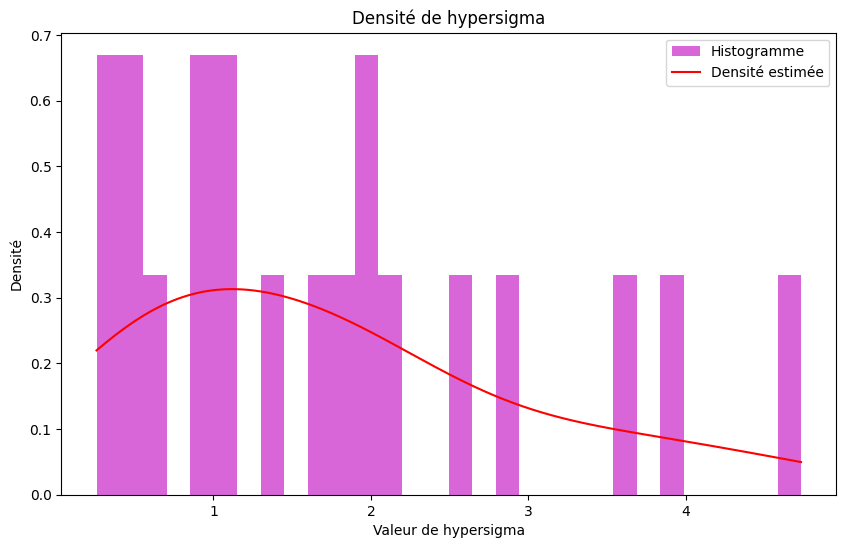

In [155]:
# Extraction et aplatissement de hypersigma
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de hypersigma')
plt.xlabel('Valeur de hypersigma')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

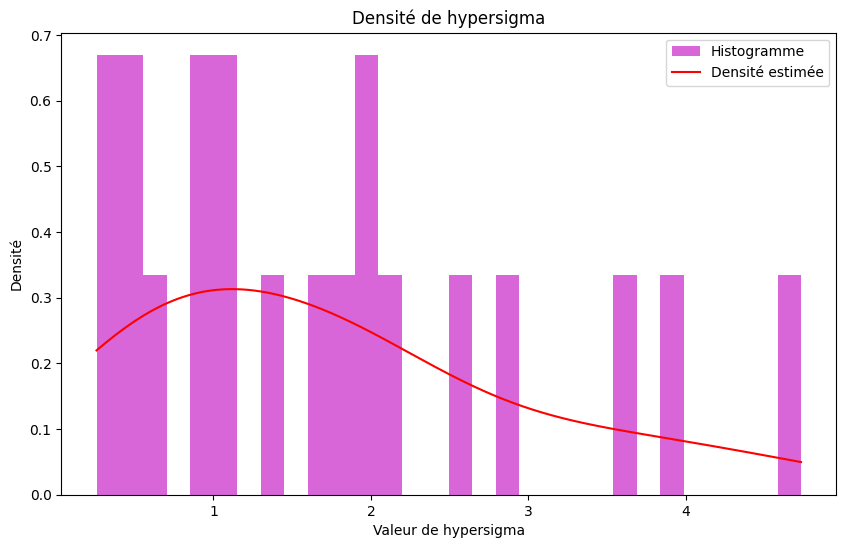

In [ ]:
# Extraction et aplatissement de hypersigma
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de hypersigma')
plt.xlabel('Valeur de hypersigma')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

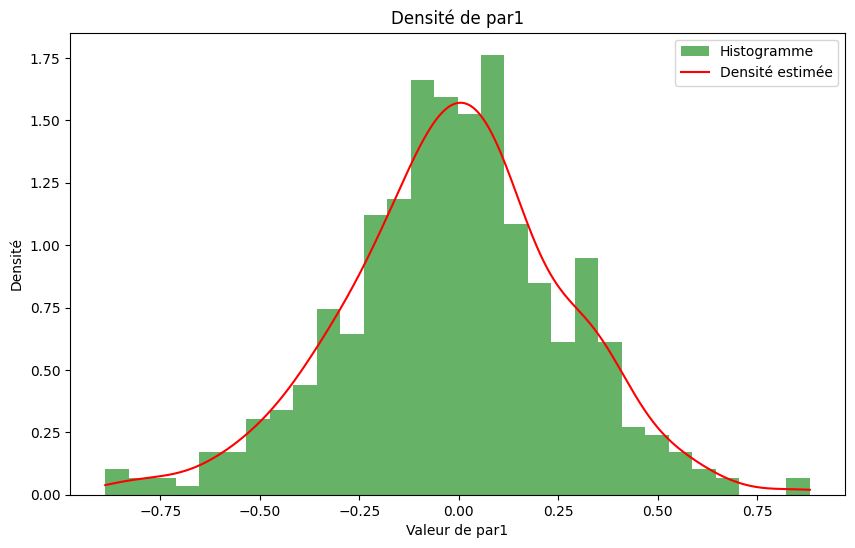

In [127]:
# Extraction et aplatissement du paramètre par1
par1 = toyG["Paramètre_1"]
par1_flat = par1.flatten()

# Estimation de la densité de probabilité
density_par1 = gaussian_kde(par1_flat)
x_vals = np.linspace(min(par1_flat), max(par1_flat), 1000)  # Générer 1000 points entre le min et le max de par1_flat
density_vals_par1 = density_par1(x_vals)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par1_flat, bins=30, density=True, alpha=0.6, color='g', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals, density_vals_par1, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de par1')
plt.xlabel('Valeur de par1')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

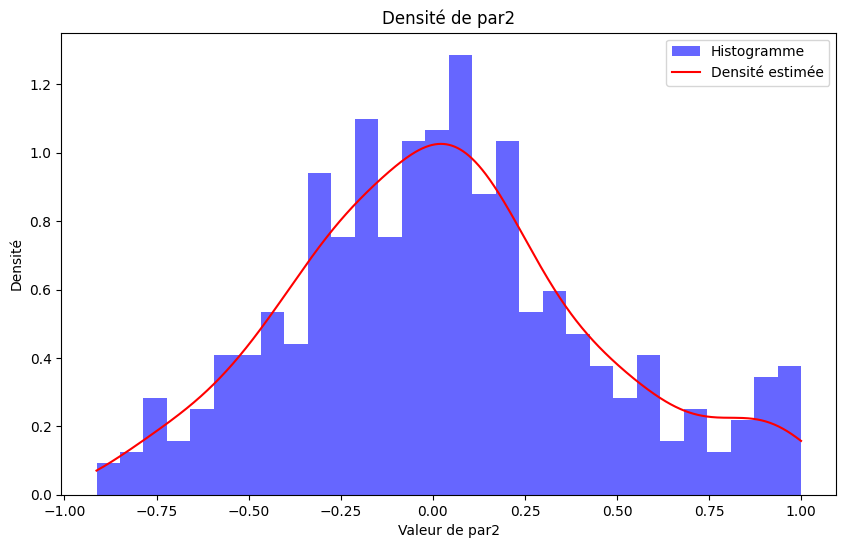

In [128]:
# Extraction et aplatissement du paramètre par2
par2 = toyG["Paramètre_2"]
par2_flat = par2.flatten()

# Estimation de la densité de probabilité
density_par2 = gaussian_kde(par2_flat)
x_vals_par2 = np.linspace(min(par2_flat), max(par2_flat), 1000)
density_vals_par2 = density_par2(x_vals_par2)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par2_flat, bins=30, density=True, alpha=0.6, color='b', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_par2, density_vals_par2, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de par2')
plt.xlabel('Valeur de par2')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

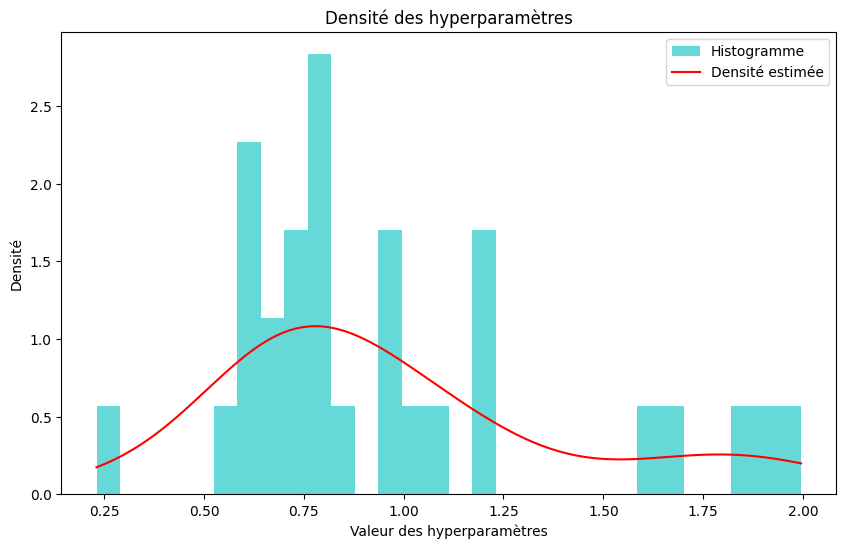

In [131]:
# Extraction et aplatissement des hyperparamètres
hyper_flat = hyper.flatten()

# Estimation de la densité de probabilité
density_hyper = gaussian_kde(hyper_flat)
x_vals_hyper = np.linspace(min(hyper_flat), max(hyper_flat), 1000)
density_vals_hyper = density_hyper(x_vals_hyper)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hyper_flat, bins=30, density=True, alpha=0.6, color='c', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hyper, density_vals_hyper, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité des hyperparamètres')
plt.xlabel('Valeur des hyperparamètres')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

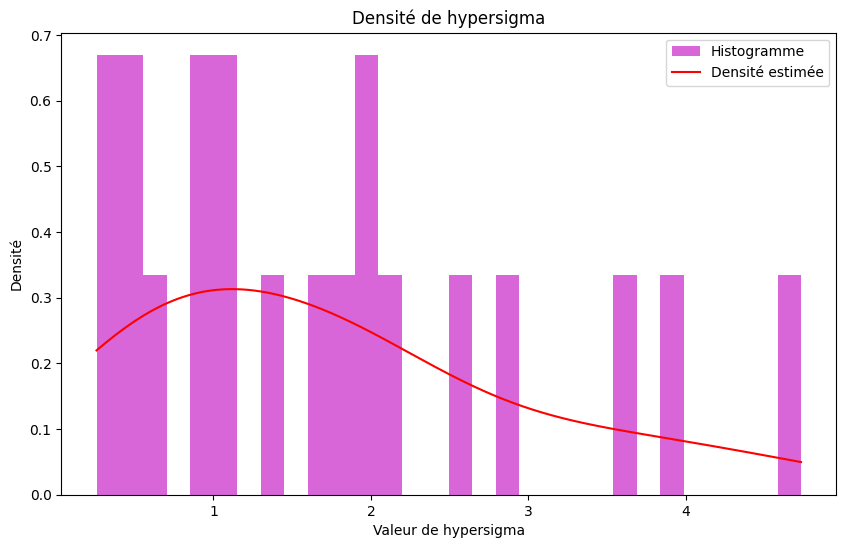

In [132]:
# Extraction et aplatissement de hypersigma
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de hypersigma')
plt.xlabel('Valeur de hypersigma')
plt.ylabel('Densité')
plt.legend()

# Afficher le graphique
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

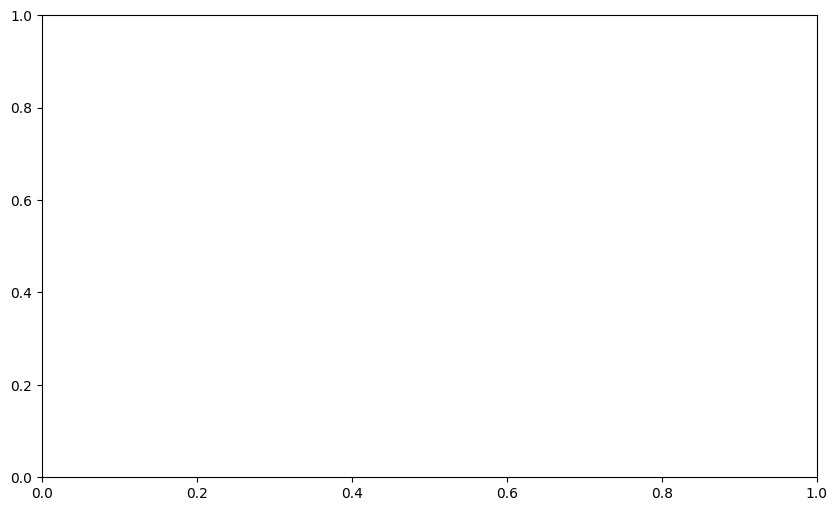

In [158]:
import matplotlib.pyplot as plt

# Tracer le temps CPU en fonction de la distance du paramètre 1
plt.figure(figsize=(10, 6))  # Définir la taille de la figure
plt.plot(toyG["Distance paramètre 1"], toyG["Temps CPU par itération"], marker='o', linestyle='-', color='b')  # Tracer la ligne avec des points
plt.title('Temps CPU en fonction de la distance du paramètre 1')  # Titre du graphique
plt.xlabel('Distance Paramètre 1')  # Étiquette de l'axe des x
plt.ylabel('Temps CPU (s)')  # Étiquette de l'axe des y
plt.grid(True)  # Afficher la grille
plt.show()  # Afficher le graphique